# Implementing the DDPM model in Ho et al

In [ ]:
from datasets import load_dataset,load_dataset_builder
from nn import inplace, DataLoaders
from learner import TrainCB, DeviceCB, ProgressCB, MetricsCB, BatchSchedCB, Learner
import torch
import torchvision.transforms.functional as TF,torch.nn.functional as F
from functools import partial
from torch import tensor,nn,optim
from torch.optim import lr_scheduler
from pathlib import Path

In [ ]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

In [ ]:
bs=128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([5, 9, 8, 3, 3, 2, 2, 0, 2, 6]))

## Training the U-Net

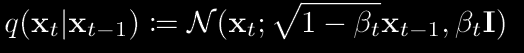

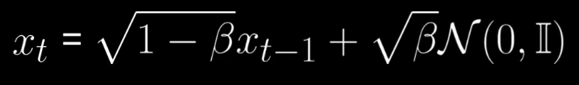

Repeated Transition Function converts an image with a complex distribution of pixels into normally disstributed noise eventually.

The above distribution can be rewritten like the lower image using some math

a linear scheduler is applied to B, which iss useful in the reverse process of converting Normally disstributed noise back to image by initially
making big jumps and then smaller jumps.

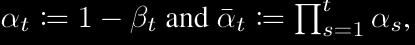

Suppose we let a = 1 - B and epsilon be the added noise from N(0,1). We do the recurrence relationship for xt, and we will get the equation in the bracket of step 5 below

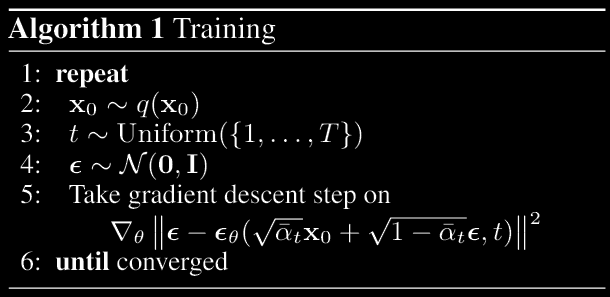

There's lots of complex math that gives the loss function in step 5 where loss is just a squared difference between the actual noise and and the predicted noise.

1) Sample an image
2) Uniformly choose a time step t
3) generate gaussian noise
4) generate the new noisy image xt at time step t
5) feed xt to neural network that predicts noise (UNet). Inputs are xt (noised image), t(level of noise) and the target(actual noise)
6) Neural network predicts the noise and we check the loss and it trains

The actual UNet model (steps 5-6) is just taken from huggingface

## Sampling

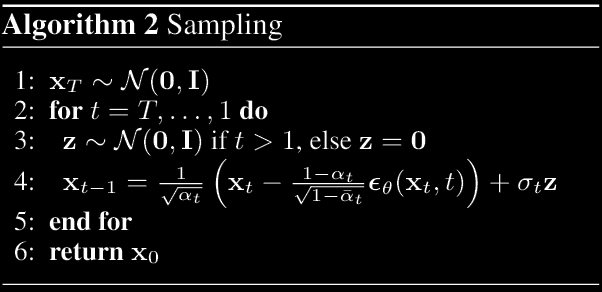

There's extra math that lets you denoise the image in step 4 by subtract the predicted noise from xt to get xt-1

1) Generate Gaussian Noise
2) iteratively remove noise



In [ ]:
from diffusers import UNet2DModel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

In [ ]:
n_steps = 10
beta = torch.linspace(0,0.8,n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)
alpha_bar

tensor([1.0000, 0.9111, 0.7491, 0.5494, 0.3540, 0.1967, 0.0918, 0.0347, 0.0100,
        0.0020])

In [ ]:
t = torch.randint(0, n_steps, (10,), dtype=torch.long)
t

tensor([1, 8, 5, 1, 7, 6, 3, 9, 9, 4])

You can index a tensor using the values from another tensor

In [ ]:
alpha_bart = alpha_bar[t]
alpha_bart

tensor([0.9111, 0.0100, 0.1967, 0.9111, 0.0347, 0.0918, 0.5494, 0.0020, 0.0020,
        0.3540])

In [ ]:
class DDPMCB(TrainCB):
    def __init__(self , n_steps, beta_min, beta_max):
        super().__init__()
        self.n_steps, self.beta_min, self.beta_max = n_steps, beta_min, beta_max
        #schedule the beta with linearly
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0) #cumulative product causes alpha_bar to decrease over time
        self.sigma = self.beta.sqrt() #used in the reverse processs (see 3.2 of paper)

    def predict(self, learn):
        learn.preds = learn.model(*learn.batch[0]).sample #model.sample() will do the reverse diffusion and predict the noise

    def before_batch(self, learn): #Add gaussian noise to batch before passing in to the Unet, modify learn.batch
        device = learn.batch[0].device
        epsilon = torch.randn(learn.batch[0].shape, device=device)
        self.x0 = learn.batch[0]
        self.alpha_bar = self.alpha_bar.to(device)
        n = self.x0.shape[0] #number of images
        #uniformly select n timesteps from the range of 0 to n_steps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        alpha_bart = self.alpha_bar[t].reshape(-1,1,1,1).to(device) #reshaping for the alphabart to fit across the n_inputs axis
        xt = alpha_bart.sqrt()*self.x0 + (1-alpha_bart).sqrt()*epsilon #formula to get xt
        #update batch to noised images
        learn.batch = ((xt, t), epsilon)


    #PLSSS learn this part idk how the sampling part works

    @torch.no_grad()
    def sample(self, model, sz):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #generate gaussian noise Xt
        x_t = torch.randn(sz, device=device)
        preds = []
        # iterate from T to 0
        for t in reversed(range(self.n_steps)):
            z = torch.randn(sz, device=device) if t > 1 else torch.zeros(sz, device=device)
            alpha_t = self.alpha[t]
            alpha_bart = self.alpha_bar[t]
            prediction = model(x_t, t).sample
            sigma_t = self.sigma[t]
            x_t = (1/alpha_t.sqrt()) * (x_t - ((1-alpha_t) / (1-alpha_bart).sqrt()) * prediction) + (sigma_t * z)
            preds.append(x_t.cpu())
        return preds












In [ ]:
lr = 4e-3
epochs = 5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

{'loss': '0.060', 'epoch': 0, 'train': True}
{'loss': '0.023', 'epoch': 0, 'train': False}


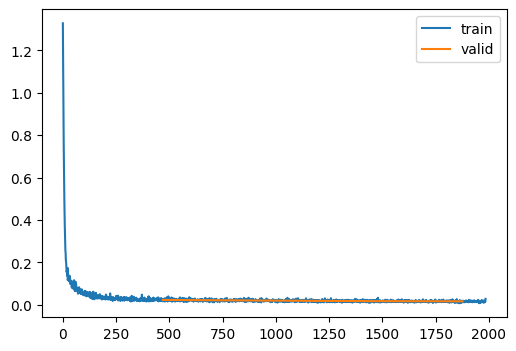

{'loss': '0.022', 'epoch': 1, 'train': True}
{'loss': '0.020', 'epoch': 1, 'train': False}
{'loss': '0.019', 'epoch': 2, 'train': True}
{'loss': '0.018', 'epoch': 2, 'train': False}
{'loss': '0.017', 'epoch': 3, 'train': True}
{'loss': '0.017', 'epoch': 3, 'train': False}


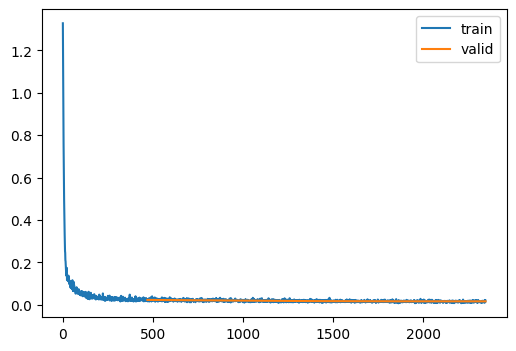

{'loss': '0.015', 'epoch': 4, 'train': True}
{'loss': '0.017', 'epoch': 4, 'train': False}


In [16]:
learn.fit(epochs)

In [17]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [18]:
torch.save(learn.model, mdl_path/'fashion_ddpm.pkl')

In [19]:
learn.model = torch.load(mdl_path/'fashion_ddpm.pkl')

<ipython-input-19-54b3d04d33c8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learn.model = torch.load(mdl_path/'fashion_ddpm.pkl')


In [34]:
samples = ddpm_cb.sample(learn.model, (1, 1, 32, 32))
len(samples)

1000

In [30]:
from nn import show_img
import matplotlib.pyplot as plt

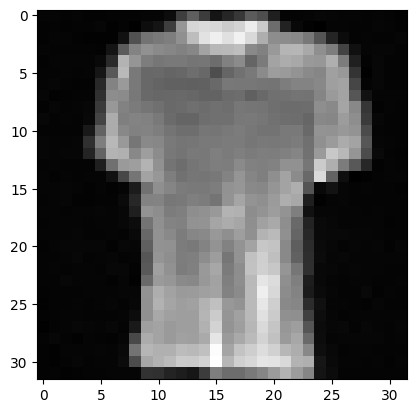

In [37]:
plt.imshow(samples[-1].squeeze(), cmap='gray')

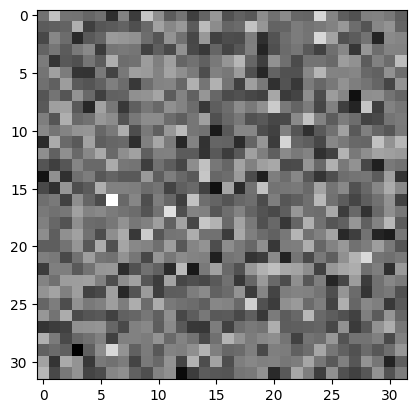

In [38]:
plt.imshow(samples[0].squeeze(), cmap='gray')

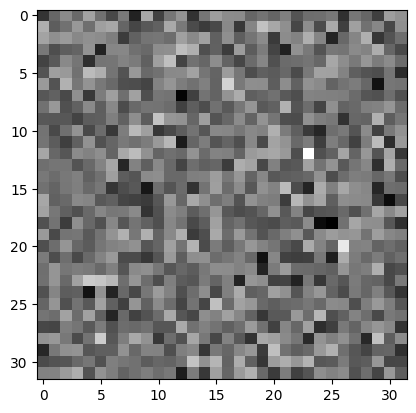

In [39]:
plt.imshow(samples[200].squeeze(), cmap='gray')

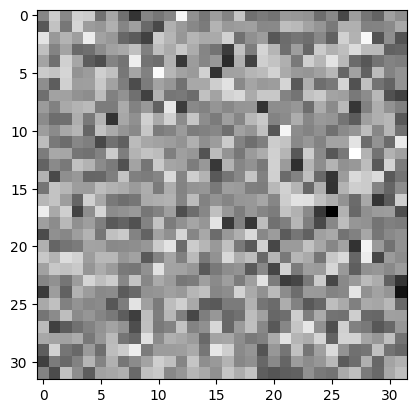

In [40]:
plt.imshow(samples[400].squeeze(), cmap='gray')

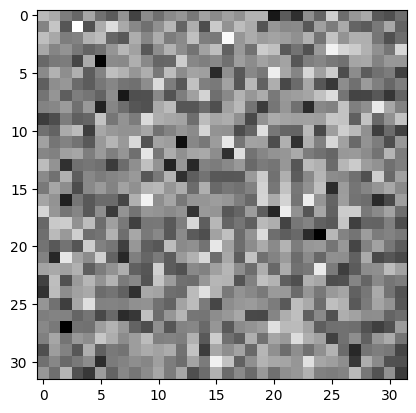

In [41]:
plt.imshow(samples[600].squeeze(), cmap='gray')

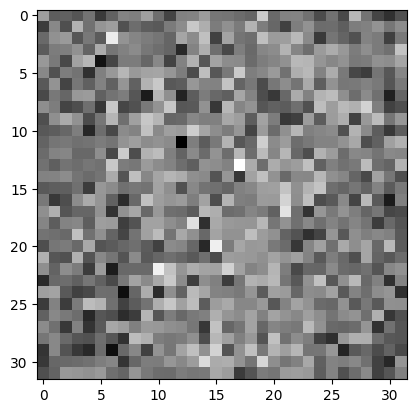

In [42]:
plt.imshow(samples[800].squeeze(), cmap='gray')

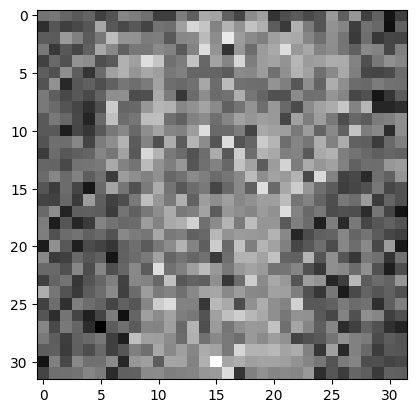

In [43]:
plt.imshow(samples[900].squeeze(), cmap='gray')

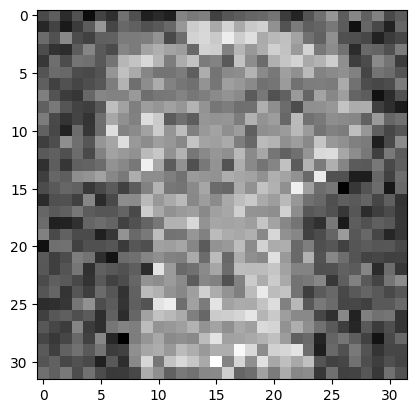

In [44]:
plt.imshow(samples[950].squeeze(), cmap='gray')

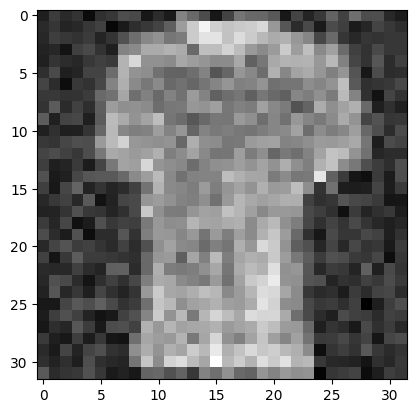

In [45]:
plt.imshow(samples[980].squeeze(), cmap='gray')

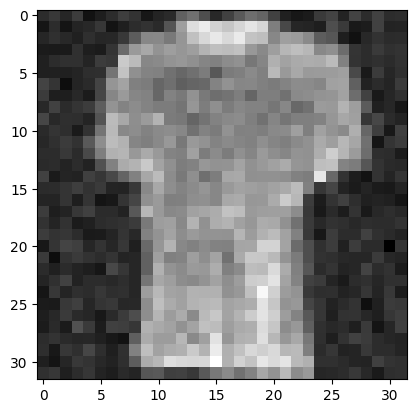

In [46]:
plt.imshow(samples[990].squeeze(), cmap='gray')

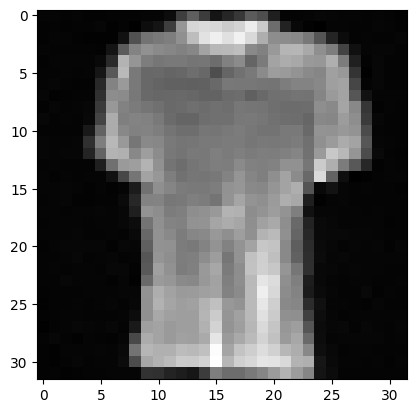

In [48]:
plt.imshow(samples[-1].squeeze(), cmap='gray')